In [1]:
import sys, os
sys.path.append("..")
import torch

from mune.networks import AgentModel

### config

In [2]:
modalities_config = {
    "vision": {
        "type": "vision"
    },
    "proprio": {
        "type": "proprio",
        "in_features": 4
    }
}

In [3]:
config = {
    "action_output_dim": 4,
    "modalities_config": modalities_config,
    "determ_state_dim": 200,
    "stoch_state_dim": 30,
    "min_stddev": 0.1,
    "reward_hidden_dim": 100,
    "reward_n_layers": 2,
    "value_hidden_dim": 100,
    "value_n_layers": 2,
    "action_hidden_dim": 100,
    "action_n_layers": 2
}

In [4]:
agent_model = AgentModel(**config)

In [5]:
agent_model

AgentModel(
  (encoder_modalities): ModuleDict(
    (vision): VisionEncoder(
      (conv_encoder): Sequential(
        (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
        (relu1): ReLU()
        (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (relu2): ReLU()
        (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
        (relu3): ReLU()
        (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
        (relu4): ReLU()
      )
    )
    (proprio): ProprioEncoder(
      (fc): Linear(in_features=4, out_features=32, bias=True)
    )
  )
  (decoder_modalities): ModuleDict(
    (vision): VisionDecoder(
      (fc_deter_stoch): Linear(in_features=230, out_features=1024, bias=True)
      (convt_decoder): Sequential(
        (convt1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
        (relu1): ReLU()
        (convt2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
        (relu2): ReLU()
        (convt3): Conv

## Multi-steps inference

In [6]:
%%time

observations = {
    "vision": torch.randn((1, 3, 64, 64)),
    "proprio": torch.randn((1, 4))
}

prev_action = torch.zeros(1, 4)
prev_action[:, 1] = 1

prev_determ_state = torch.randn((1, 200))
prev_stoch_state = torch.randn((1, 30))

with torch.no_grad():
    rollout_values = []
    for step in range(12):
        output = agent_model(observations=observations, 
                             prev_action=prev_action, 
                             prev_determ_state=prev_determ_state, 
                             prev_stoch_state=prev_stoch_state)
        rollout_values.append(output)
        prev_action = output['pred_action'].logits
        prev_determ_state = output['transitions']['determ_state']
        prev_stoch_state = output['transitions']['stoch_state_posterior']['stoch_state']

CPU times: user 131 ms, sys: 5.44 ms, total: 136 ms
Wall time: 80.2 ms


In [7]:
import matplotlib.pyplot as plt

In [8]:
observations

{'vision': tensor([[[[ 1.3149e+00,  1.3270e+00, -2.6609e+00,  ...,  1.5007e+00,
            -4.7207e-01, -1.8779e+00],
           [ 2.7730e-03, -4.5486e-01,  1.0113e+00,  ..., -1.0998e+00,
            -7.8806e-01,  1.7251e+00],
           [-7.9358e-01,  3.1484e-01, -2.9042e-01,  ...,  9.9734e-01,
             4.5569e-01,  1.2526e+00],
           ...,
           [ 1.5394e+00, -5.1940e-01, -1.5224e-01,  ...,  3.7831e-01,
             2.9143e-01, -4.7612e-01],
           [-1.3578e+00, -1.5863e-01, -4.9834e-01,  ...,  7.1794e-01,
             2.2317e-01,  1.6033e+00],
           [-4.7202e-01,  2.1355e-01, -1.7412e+00,  ..., -1.6463e+00,
             3.7532e-01, -2.1312e+00]],
 
          [[-8.1653e-02, -7.3217e-01,  1.7501e-02,  ..., -5.2078e-01,
            -2.9071e-01,  5.6766e-01],
           [-2.1956e+00,  4.0482e-01, -5.3978e-01,  ..., -1.5576e+00,
             3.7470e-01,  2.9674e-01],
           [ 7.0028e-01,  8.0487e-01, -7.1832e-01,  ..., -6.2973e-01,
            -5.3851e-01,  1.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


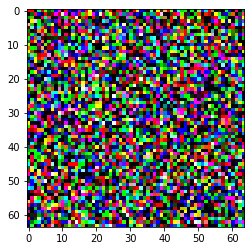

In [9]:
plt.imshow(observations['vision'].squeeze(0).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


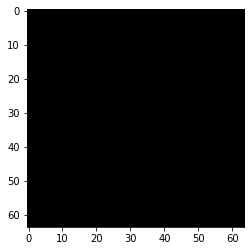

In [10]:
plt.imshow(rollout_values[11]['pred_observations']['vision'].squeeze(0).permute(1, 2, 0))